In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torch.nn as nn

### Creating the model

In [2]:
MODELS = {
    "ViT-B/32":       "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
}

In [3]:
!wget {MODELS["ViT-B/32"]} -O model.pt

--2021-03-08 19:41:06--  https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.19, 13.107.213.19, 2620:1ec:bdf::19, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353976522 (338M) [application/octet-stream]
Saving to: ‘model.pt’

model.pt            100%[===================>] 337.58M   124MB/s    in 2.7s    

2021-03-08 19:41:09 (124 MB/s) - ‘model.pt’ saved [353976522/353976522]



In [4]:
model = torch.jit.load("model.pt").cuda().eval()
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [5]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


### Downloading the dataset

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
cd gdrive/MyDrive/

/content/gdrive/MyDrive


In [8]:
try:
  !rm Brueghel.zip?dl=0
except:
  print("Does not exist")

In [9]:
!rm -rf Brueghel

In [10]:
!wget 'https://www.dropbox.com/s/nljxhtct5d7285h/Brueghel.zip?dl=0'
!unzip Brueghel.zip?dl=0

--2021-03-08 19:43:55--  https://www.dropbox.com/s/nljxhtct5d7285h/Brueghel.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/nljxhtct5d7285h/Brueghel.zip [following]
--2021-03-08 19:43:55--  https://www.dropbox.com/s/raw/nljxhtct5d7285h/Brueghel.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4084d097db82cb049f28516fcb.dl.dropboxusercontent.com/cd/0/inline/BKWsE2BZXe0kCWg0dGJjpdeAlHkJlASLoxfLOLsB_FsqBnU-nlDgCIGC2HYamJfR3yOusGebQF1vmSWWZmPGQcLf4Cc8NlVYt69Qh5Bg7CviJMSE7HW9-V3GAiMB5SRWlhY/file# [following]
--2021-03-08 19:43:55--  https://uc4084d097db82cb049f28516fcb.dl.dropboxusercontent.com/cd/0/inline/BKWsE2BZXe0kCWg0dGJjpdeAlHkJlASLoxfLOLsB_FsqBnU-nlDgCIGC2HYamJfR3yOusGebQF1vmSWWZmPGQcLf4Cc8NlVYt69Qh5Bg7C

### Loading dataset

In [11]:
from torchvision import datasets
import sys, os
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize
import cv2
from PIL import Image
from numpy import asarray

def dataload(path1,  size = (224, 224, 3)):
    """
    inputs: path to images folder
    returns: arrays contains imgs 
    """
    onlyfiles1 = [f for f in os.listdir(path1) if os.path.isfile(os.path.join(path1, f))]
    onlyfiles1.sort()

    visible = np.ndarray(shape=(len(onlyfiles1), size[0], size[1], size[2]), dtype = np.float32)
    i = 0
    for img_name in tqdm(onlyfiles1):
      img_path = path1 + "/" + img_name
      img = np.array(Image.open(img_path, mode="r").resize((size[0], size[1], size[2])))
      visible[i] = img 
    print("\t############# All VISIBLE images to array ##########")
    return visible

def dataLabels(path1):
    onlyfiles1 = [f for f in os.listdir(path1) if os.path.isfile(os.path.join(path1, f))]

    labels = []
    for img_name in tqdm(onlyfiles1):
        labels.append(img_name)

    return labels

In [12]:
main_path = os.path.abspath(os.getcwd())
data_dir = main_path + '/Brueghel/'
print(data_dir)

/content/gdrive/My Drive/Brueghel/


In [13]:
!mv  Brueghel train
!mkdir Brueghel
!mv train Brueghel
!cd Brueghel

In [14]:
dsets = datasets.ImageFolder(root="/content/gdrive/My Drive/Brueghel/", transform=preprocess)

In [15]:
dsets

Dataset ImageFolder
    Number of datapoints: 1587
    Root location: /content/gdrive/My Drive/Brueghel/
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bicubic)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [16]:
labels = dataLabels("/content/gdrive/My Drive/Brueghel/train/")

100%|██████████| 1587/1587 [00:00<00:00, 524618.57it/s]


In [17]:
labels[:10]

['Venus as Ceres with Apollo.jpg',
 'Sheet of Studies of Peasants.jpg',
 'Woodland Scene with Bears.jpg',
 'The Four Elements (Bucharest).jpg',
 'Garden of Eden with Creation of Eve.jpg',
 'View of the Temples of Venus and of Diana in Baia from the South.jpg',
 'Fruit and Flower Garland Around the Virgin and Child (Switzerland).jpg',
 'The Flatterers (Amsterdam).jpg',
 'The Sense of Taste.jpg',
 "The Flood with Noah's Ark (London).jpg"]

In [18]:
data_loader = torch.utils.data.DataLoader(dsets, batch_size=16, shuffle=False, num_workers=6)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
device

'cuda'

In [21]:
images, labels = next(iter(data_loader))
print("Images shape: ", images.shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Images shape:  torch.Size([16, 3, 224, 224])


In [22]:
img = images[0].unsqueeze(0)
print(img.shape)

torch.Size([1, 3, 224, 224])


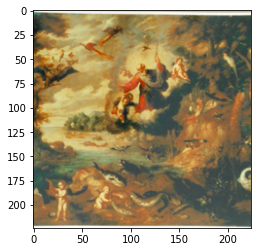

In [23]:
plt.imshow(img[0].permute(1, 2, 0).detach().numpy())

### Regional Max-Pooling

In [24]:
from torchvision import datasets, transforms, models

input_resolution = 800
transformation = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])
dsets = datasets.ImageFolder(root="/content/gdrive/My Drive/Brueghel/", transform=transformation)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [25]:
dsets

Dataset ImageFolder
    Number of datapoints: 1587
    Root location: /content/gdrive/My Drive/Brueghel/
    StandardTransform
Transform: Compose(
               Resize(size=800, interpolation=bicubic)
               CenterCrop(size=(800, 800))
               ToTensor()
           )

In [26]:
data_loader = torch.utils.data.DataLoader(dsets, batch_size=16, shuffle=False, num_workers=2)

In [27]:
import math
import torch.nn.functional as F

def rmac(x, L=5, eps=1e-6):
    ovr = 0.4 # desired overlap of neighboring regions
    steps = torch.Tensor([2, 3, 4, 5, 6, 7]) # possible regions for the long dimension

    W = x.size(3)
    H = x.size(2)

    w = min(W, H)
    w2 = math.floor(w/2.0 - 1)

    b = (max(H, W)-w)/(steps-1)
    (tmp, idx) = torch.min(torch.abs(((w**2 - w*b)/w**2)-ovr), 0) # steps(idx) regions for long dimension

    # region overplus per dimension
    Wd = 0;
    Hd = 0;
    if H < W:  
        Wd = idx.item() + 1
    elif H > W:
        Hd = idx.item() + 1

    v = F.max_pool2d(x, (x.size(-2), x.size(-1)))
    v = v / (torch.norm(v, p=2, dim=1, keepdim=True) + eps).expand_as(v)

    for l in range(1, L+1):
        wl = math.floor(2*w/(l+1))
        wl2 = math.floor(wl/2 - 1)

        if l+Wd == 1:
            b = 0
        else:
            b = (W-wl)/(l+Wd-1)
        cenW = torch.floor(wl2 + torch.Tensor(range(l-1+Wd+1))*b) - wl2 # center coordinates
        if l+Hd == 1:
            b = 0
        else:
            b = (H-wl)/(l+Hd-1)
        cenH = torch.floor(wl2 + torch.Tensor(range(l-1+Hd+1))*b) - wl2 # center coordinates
            
        for i_ in cenH.tolist():
            for j_ in cenW.tolist():
                if wl == 0:
                    continue
                R = x[:,:,(int(i_)+torch.Tensor(range(wl)).long()).tolist(),:]
                R = R[:,:,:,(int(j_)+torch.Tensor(range(wl)).long()).tolist()]
                vt = F.max_pool2d(R, (R.size(-2), R.size(-1)))
                vt = vt / (torch.norm(vt, p=2, dim=1, keepdim=True) + eps).expand_as(vt)
                v += vt

    return v

In [28]:
model = torch.jit.load("model.pt").cuda().eval()

for param in model.parameters():
    param.requires_grad = False

class MyModel2(nn.Module):
  def __init__(self, input_resolution: int, patch_size: int, width: int):
    super(MyModel2, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=(3, 3), bias=False)
    output_size = (1,1)
    self.pooling = nn.AdaptiveMaxPool2d(output_size)
  
  def forward(self, image):
    out = self.conv1(image)             #[1, 768, 257, 257]
    #Regional Max-Pooling
    output = out / (torch.norm(out, p=2, dim=1, keepdim=True) + 1e-12).expand_as(out)
    #output = torch.nn.functional.normalize(out, p=2.0, dim=1)
    output = rmac(output)
    return output

In [29]:
vision_width = model.visual.conv1.weight.shape[0]
vision_patch_size = model.visual.conv1.weight.shape[-1]

grid_size = round((model.visual.positional_embedding.shape[0] - 1) ** 0.5)
image_resolution = vision_patch_size * grid_size
vision_heads = vision_width // 64

print("vision_width", vision_width)
print("vision_patch_size", vision_patch_size)
print("grid_size", grid_size)
print("image_resolution", image_resolution)
print("vision_heads", vision_heads)

vision_width 768
vision_patch_size 32
grid_size 7
image_resolution 224
vision_heads 12


In [30]:
conv = MyModel2(input_resolution = image_resolution, patch_size = vision_patch_size, width = vision_width)

print(conv)
for param in conv.parameters():
  print(param.shape)

weights_conv = model.visual.conv1.weight
print("Initial ViT Model weights: ", weights_conv.shape)

#Giving the weights of initial CLIP ViT to the convolution network
with torch.no_grad():
    conv.conv1.weight = torch.nn.Parameter(weights_conv.type(torch.FloatTensor))

MyModel2(
  (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(3, 3), bias=False)
  (pooling): AdaptiveMaxPool2d(output_size=(1, 1))
)
torch.Size([768, 3, 32, 32])
Initial ViT Model weights:  torch.Size([768, 3, 32, 32])


In [31]:
def get_features(dataset):
    all_features = []
    all_labels = []
    imgs = []
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset)):
            features = conv(images.to(device))
            imgs.append(images)
            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy(), imgs

In [32]:
from torch.utils.data import DataLoader
conv = conv.eval().to(device)

# Calculate the image features
dsets = datasets.ImageFolder(root="/content/gdrive/My Drive/Brueghel/", transform=preprocess)

features, _, imgs = get_features(dsets)

100%|██████████| 1587/1587 [01:17<00:00, 20.58it/s]


In [36]:
features[0].squeeze(1).squeeze(1).shape

(768,)

In [37]:
features_np = np.zeros((len(features), features[0].shape[0]))
for i, value in enumerate(features):
  value = value.squeeze(1).squeeze(1)
  features_np[i] = value

In [38]:
# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pca = PCA(n_components=100, random_state=22)
pca.fit(features_np)
target= pca.transform(features_np)
print("After PCA: ", target.shape)

After PCA:  (1587, 100)


In [39]:
# clustering and dimension reduction
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=32,n_jobs=-1, random_state=22)
kmeans.fit(target)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=32, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=22, tol=0.0001, verbose=0)

In [40]:
# holds the cluster id and the images { id: [images] }
groups = {}
for i, cluster in enumerate(kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(i)
    else:
        groups[cluster].append(i)

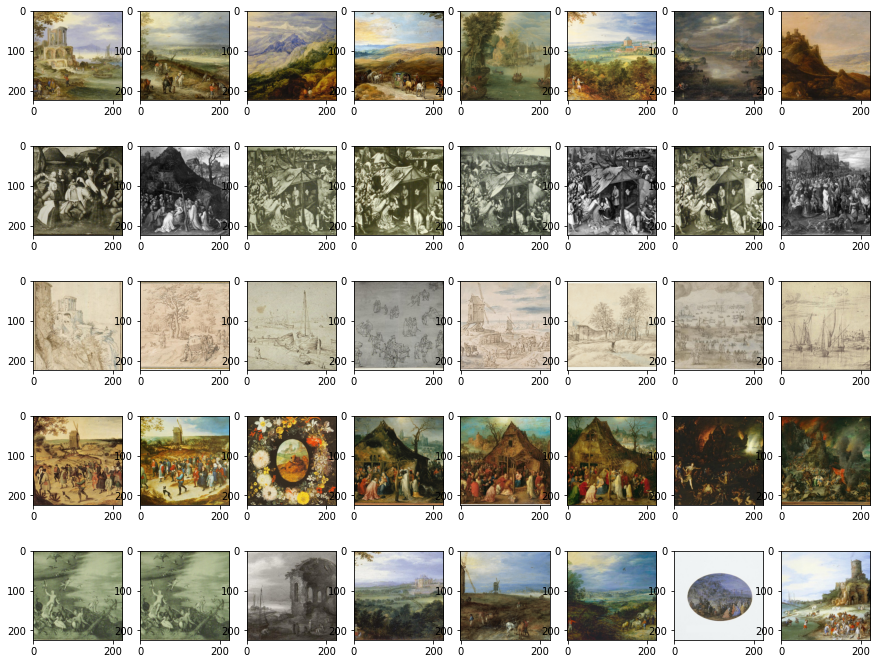

In [41]:
import matplotlib.pyplot as plt

#Cluster 0
fig, ax = plt.subplots(5, 8, figsize=(15, 12))

for i in range(5):
  for j in range(8):
    img_id = groups[i][j]
    img = imgs[img_id][0]
    ax[i][j].imshow(img.permute(1,2,0))

In [43]:
groups[0]

[309,
 380,
 605,
 607,
 670,
 674,
 769,
 774,
 777,
 778,
 928,
 982,
 1008,
 1019,
 1067,
 1070,
 1186,
 1312,
 1348,
 1354,
 1429,
 1443,
 1542,
 1543]

In [45]:
cluster0 = [[309,380,605,607,670,674,769,774],[
 777,
 778,
 928,
 982,
 1008,
 1019,1067,1070],[1186,1312,1348,1354,1429,1443,1542,1543]]

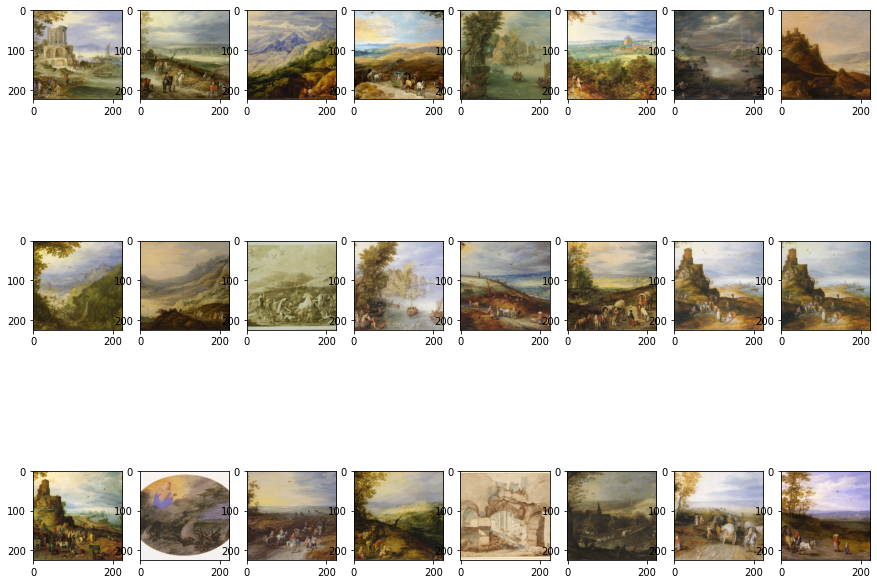

In [46]:
#Cluster 0
fig, ax = plt.subplots(3, 8, figsize=(15, 12))

for i in range(3):
  for j in range(8):
    img_id = cluster0[i][j]
    img = imgs[img_id][0]
    ax[i][j].imshow(img.permute(1,2,0))

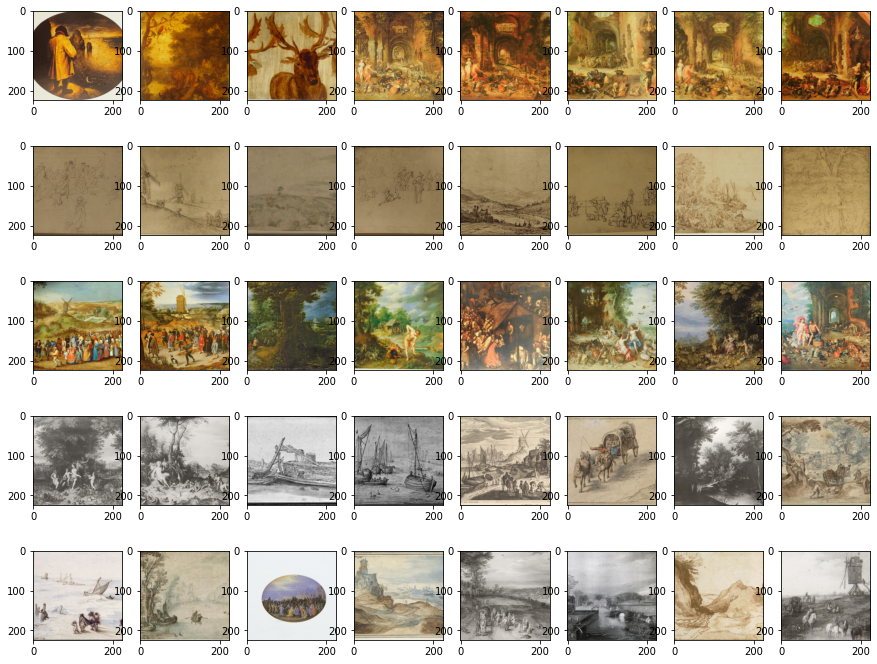

In [54]:
import matplotlib.pyplot as plt

#Cluster 10-15
fig, ax = plt.subplots(5, 8, figsize=(15, 12))

for i in range(0, 5):
  for j in range(8):
    index = i + 10
    img_id = groups[index][j]
    img = imgs[img_id][0]
    ax[i][j].imshow(img.permute(1,2,0))

### Using all Visual network for ViT model

In [23]:
MODELS = {
    "ViT-B/32":       "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
}
!wget {MODELS["ViT-B/32"]} -O model.pt

--2021-03-08 18:47:38--  https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.19, 13.107.213.19, 2620:1ec:bdf::19, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353976522 (338M) [application/octet-stream]
Saving to: ‘model.pt’

model.pt            100%[===================>] 337.58M  29.0MB/s    in 15s     

2021-03-08 18:47:53 (21.9 MB/s) - ‘model.pt’ saved [353976522/353976522]



In [24]:
import numpy as np
import torch
from tqdm.notebook import tqdm

In [25]:
model = torch.jit.load("model.pt").cuda().eval()
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

In [26]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"

In [42]:
def get_features(dataset):
    all_features = []
    all_labels = []
    imgs = []
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset)):
            features = model.encode_image(images.to(device))
            imgs.append(images)
            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy(), imgs

In [43]:
from torch.utils.data import DataLoader

model = torch.jit.load("model.pt").cuda().eval()
# Calculate the image features
dsets = datasets.ImageFolder(root="/content/gdrive/My Drive/Brueghel/", transform=preprocess)

features, _, imgs = get_features(dsets)

In [44]:
len(features), len(imgs), imgs[0].shape

(1587, 1587, torch.Size([1, 3, 224, 224]))

In [45]:
features_np = np.zeros((len(features), features[0].shape[0]))
for i, value in enumerate(features):
  features_np[i] = value

In [47]:
features_np.shape

(1587, 512)

In [48]:
# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pca = PCA(n_components=100, random_state=22)
pca.fit(features_np)
target= pca.transform(features_np)
print("After PCA: ", target.shape)

After PCA:  (1587, 100)


### K-Means Clustering

In [49]:
# clustering and dimension reduction
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=32,n_jobs=-1, random_state=22)
kmeans.fit(target)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=32, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=22, tol=0.0001, verbose=0)

In [51]:
kmeans.labels_[:25]

array([15,  5,  5, 21,  5,  5, 14, 14,  0,  0, 28,  0,  0,  0,  0, 12, 26,
       30, 26, 26, 22, 31,  5, 21,  3], dtype=int32)

In [54]:
# holds the cluster id and the images { id: [images] }
groups = {}
for i, cluster in enumerate(kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(i)
    else:
        groups[cluster].append(i)

In [56]:
groups[10]

[30,
 187,
 189,
 286,
 300,
 303,
 683,
 694,
 921,
 1012,
 1044,
 1046,
 1047,
 1050,
 1051,
 1065,
 1118,
 1147,
 1163,
 1164,
 1187,
 1188,
 1227,
 1292,
 1293,
 1304,
 1305,
 1330,
 1339,
 1393,
 1399,
 1401,
 1402,
 1404,
 1406,
 1413,
 1415,
 1418,
 1420,
 1421,
 1423,
 1424,
 1425,
 1426,
 1429,
 1562,
 1578]

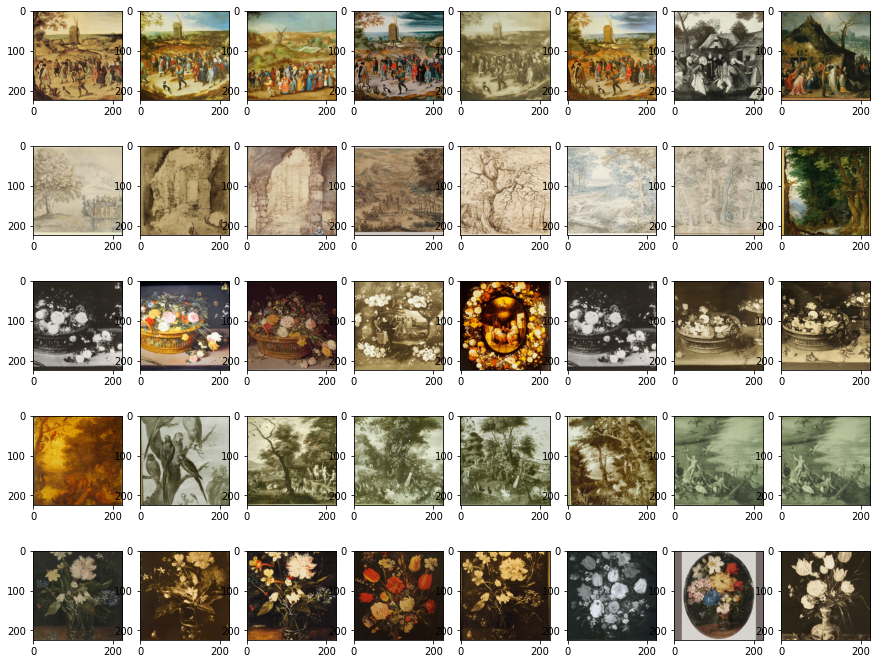

In [60]:
import matplotlib.pyplot as plt

#Cluster 0
fig, ax = plt.subplots(5, 8, figsize=(15, 12))

for i in range(5):
  for j in range(8):
    img_id = groups[i][j]
    img = imgs[img_id][0]
    ax[i][j].imshow(img.permute(1,2,0))